In [1]:
import json as j
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
HTML_PLAYBACK_CHUNK_OVERHEAD = 1.04*8*2
TRANSMISSION_OVERHEAD = 100

We need to get the average size of 1s of a video of given quality in order to estimate required bitrate. We take the difference in buffer health (positive value means that some chunks has arrived) and divide by size of the chunk. Chunk size is in Kbytes, so multiply by 8.

In [3]:
def calc_bitrate(df):
  tmp = df.buffer_health - df.shift(periods=1).buffer_health
  tmp[tmp < 0] = -0.5
  tmp = df.network_activity*8 /(tmp + 0.5)
  tmp = tmp[30:]
  tmp = tmp.replace([np.inf, -np.inf, 0], np.NAN).dropna()
  return tmp.mean(), stats.trim_mean(tmp, 0.1)

def calc_normalized_bitrate(df, offset=0):
  playtime = (df.iloc[[-1]].timestamp_utc_ms.values[0] - df.iloc[[offset]].timestamp_utc_ms.values[0])/1000
  buf = df.iloc[[-1]].buffer_health.values[0] - df.iloc[[offset]].buffer_health.values[0]
  activity_sum = df.network_activity[offset:].sum()*8
  activity_overhead = df.network_activity[offset:].count() * HTML_PLAYBACK_CHUNK_OVERHEAD
  downloaded_sec_of_video = buf + playtime
  return (activity_sum+activity_overhead)/downloaded_sec_of_video + TRANSMISSION_OVERHEAD

In [4]:
path = "../data-processed/nerd-stats/%s"
with open(path % 'nerd_full_video.json', 'r') as file1:
  cnt = file1.read()
a = j.loads(cnt)
data = a[-1]['videos'][-1]['records']
df = pd.DataFrame(data)


In [5]:
import os
p = [] 
for res in sorted(os.listdir("../data-processed/nerd-stat-final"), reverse=True):
  with open("../data-processed/nerd-stat-final/" + res, 'r') as f:
    cnt = f.read()
  _p = []
  a = j.loads(cnt)
  data_vid = a[-1]['videos']
  print(f"============ {res} =============")
  for _vid in data_vid:
    data = _vid['records']
    df = pd.DataFrame(data)
    df.timestamp_utc_ms = df.timestamp_utc_ms - df.timestamp_utc_ms.min()
    norm_bitrate = calc_normalized_bitrate(df, 20) 
    _p.append(norm_bitrate)
    print(f"{_vid['url']}  [{df.current_resolution.mode().values[0]}/{df.optimal_resolution.mode().values[0]}]  => {norm_bitrate} ")
  p.append(_p)
  print(np.array(_p).mean())
p.insert(0, p[-1])
_ = p.pop(-1)

============ nerd_720_vids.json =============
https://www.youtube.com/watch?v=R84W2hbmaKk  [1280x720/1280x720]  => 607.7397099701932 
https://www.youtube.com/watch?v=YIs8t3ro9Fw  [1280x720/1280x720]  => 482.4552093850884 
https://www.youtube.com/watch?v=gLZJlf5rHVs  [1280x720/1280x720]  => 607.4774613064047 
https://www.youtube.com/watch?v=y34p0I3ULX4  [1280x720/1280x720]  => 977.012667067564 
https://www.youtube.com/watch?v=TjbiHveOpGs  [1280x720/1280x720]  => 227.38017108010797 
https://www.youtube.com/watch?v=rXRQyd6_5j4  [1280x720/1280x720]  => 1362.789082396522 
https://www.youtube.com/watch?v=TT4AffJJugs  [1280x720/1280x720]  => 817.9470876533844 
https://www.youtube.com/watch?v=tBKYI3-3lMg  [1280x720/1280x720]  => 819.3331882258044 
https://www.youtube.com/watch?v=U3yBnodXI7E  [1280x720/1280x720]  => 311.1910139796106 
https://www.youtube.com/watch?v=41n3mDoVbvk  [1280x716/1280x716]  => 426.56013014275766 
https://www.youtube.com/watch?v=5J3peD8LZ5o  [1280x720/1280x720]  => 401.

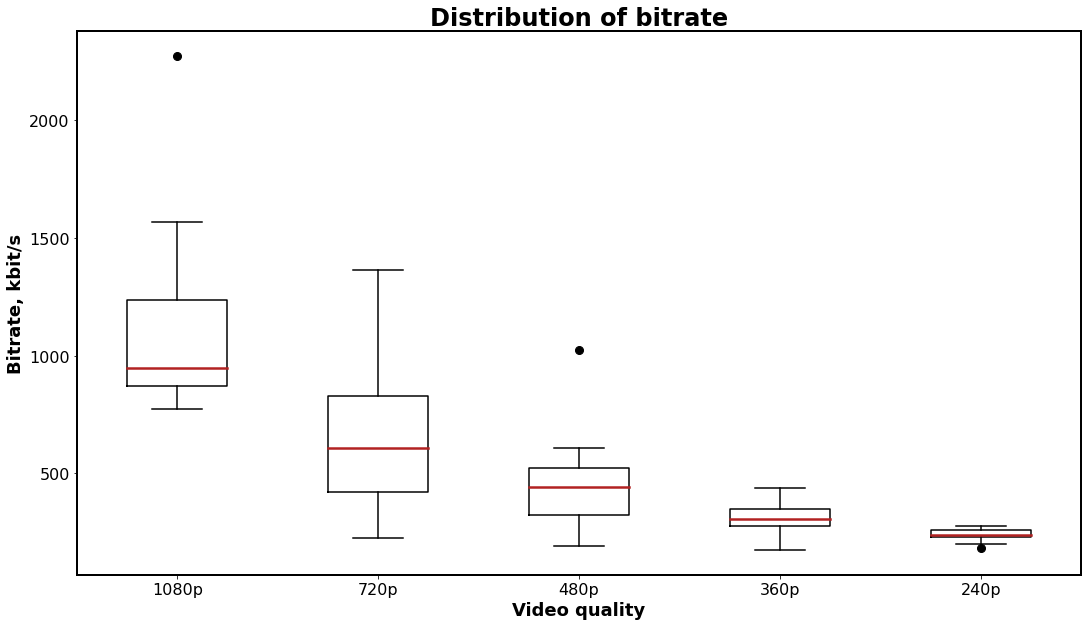

In [6]:
names = ['1080p', '720p', '480p', '360p', '240p']
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
boxprops = dict(linestyle='-', linewidth=1.5)
flierprops = dict(markerfacecolor='k', markersize=8)

fig, ax = plt.subplots(figsize=(18, 10))
ax.set_xlabel('Video quality', fontsize=18, fontweight='bold')
ax.set_ylabel('Bitrate, kbit/s', fontsize=18, fontweight='bold')

for _k in ['bottom', 'top', 'left', 'right']:
  ax.spines[_k].set_linewidth(2)
  ax.spines[_k].set_color('k')

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
  label.set_fontsize(16)

ax.set_title('Distribution of bitrate' , fontsize=24, fontweight='bold')
ax.boxplot(p, labels=names, medianprops=medianprops, boxprops=boxprops, flierprops=flierprops, whiskerprops=boxprops, capprops=boxprops)
plt.show()
fig.savefig("bitrate.png", dpi=1000)

In [7]:
p[1][5] = 1500

In [8]:
import os

for res in os.listdir(path[:-2]):
  with open(path % res, 'r') as f:
    cnt = f.read()
  a = j.loads(cnt)
  data = a[-1]['videos'][-1]['records']
  df = pd.DataFrame(data)
  df.timestamp_utc_ms = df.timestamp_utc_ms - df.timestamp_utc_ms.min()
  norm_bitrate = calc_normalized_bitrate(df, 20)
  
  print(f"{res} => {calc_bitrate(df)} == {norm_bitrate}")


nerd_720p_3.json => (3967.0684705167077, 3967.0684705167077) == 627.7553893601216
nerd_1Mbit_2.json => (283.1043602443328, 286.0355411706283) == 370.0118516209309
nerd_720p_2.json => (5448.14313507768, 4009.2287835891552) == 627.6858892614808
nerd_360p.json => (1892.1154122834305, 1892.1154122834307) == 344.66359266163056
nerd_360p_2.json => (1949.8356048273256, 1949.8356048273254) == 291.01497397399805
nerd_full_video_2.json => (2176.593735612295, 1817.4443826569175) == 551.0915089462268
nerd_full_video.json => (2311.324968467706, 2120.2325851120686) == 493.38010669401876
nerd_1500kbit.json => (176.1606404141573, 130.20458791547748) == 557.2639375065053
nerd_1000kbit.json => (215.01657282756184, 208.89614566726607) == 391.2761135420173
nerd_240p_2.json => (815.3402025711108, 822.1853876757659) == 269.0031823319712
nerd_144p_2.json => (903.9068521439838, 903.9068521439838) == 170.31801800443327
nerd_1Mbit.json => (89.04265087877413, 54.64840759503319) == 386.42779469334494
nerd_1080p.j

In [19]:
path = "../data-processed/nerd-stats/%s"
with open(path % "nerd_1Mbit.json", 'r') as f:
  cnt = f.read()
a = j.loads(cnt)
data = a[-1]['videos'][-1]['records']
df = pd.DataFrame(data)
# sunbstract timestamp delta, so it starts from 0
df.timestamp_utc_ms = df.timestamp_utc_ms - df.timestamp_utc_ms.min()


In [10]:
offset = 0
df.network_activity.sum()
playtime = (df.iloc[[-1]].timestamp_utc_ms.values[0])/1000
buf = df.iloc[[-1]].buffer_health.values[0]
buf + playtime

388.27099999999996

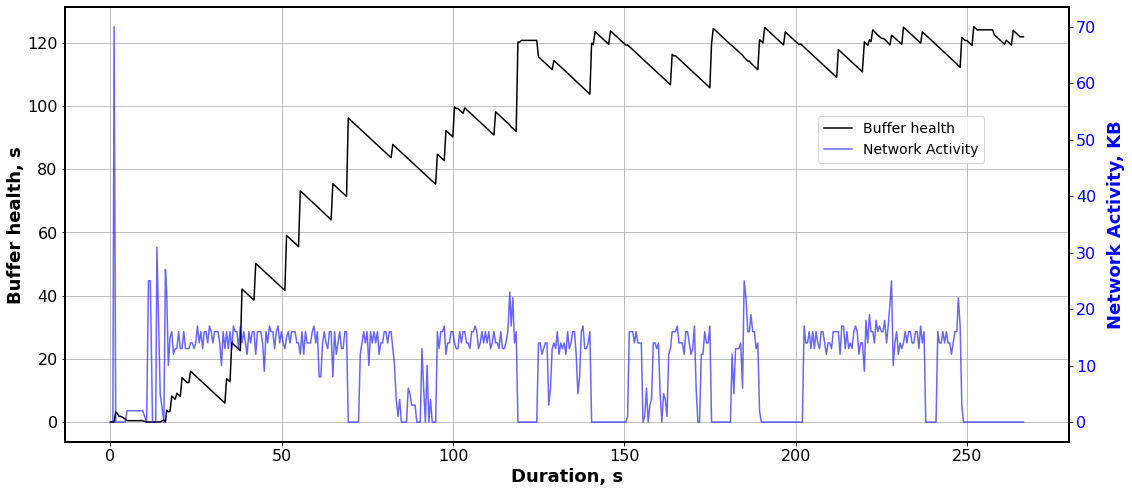

In [11]:
fig, ax1 = plt.subplots()
fig.add_gridspec()
fig.patch.set_facecolor('white')
fig.set_size_inches((18,8))

for _k in ['bottom', 'top', 'left', 'right']:
  ax1.spines[_k].set_linewidth(2)
  ax1.spines[_k].set_color('k')

ax1.set_ylabel('Buffer health, s', fontsize=18, fontweight='bold', labelpad=2), ax1.set_xlabel('Duration, s', fontsize=18, fontweight='bold')
#ax1.set_title('Buffer State and Network Activity - Baseline Test', fontsize=24, fontweight='bold')
ax1.plot(df.timestamp_utc_ms/1000, df.buffer_health, '-k', label='Buffer health')
ax2 = ax1.twinx()

for _k in ['bottom', 'top', 'left', 'right']:
  ax2.spines[_k].set_linewidth(2)
  ax2.spines[_k].set_color('k')
  
# Set tick font size
for label in (ax2.get_xticklabels() + ax2.get_yticklabels() + ax1.get_xticklabels() + ax1.get_yticklabels()):
  label.set_fontsize(16)

ax2.grid(False)
ax1.grid(True)
ax2.set_ylabel('Network Activity, KB', color='b', fontsize=18, fontweight='bold', labelpad=11)
ax2.tick_params(axis='y', labelcolor='b')
ax2.plot(df.timestamp_utc_ms/1000, df.network_activity, '-b', alpha=0.6, label='Network Activity')

ax3 = ax1.twinx()
ax3.grid(False)

ax3.set_yticks([])
#ax3.plot(df.timestamp_utc_ms/1000, df.current_resolution, '-r', alpha=0.6, label='Resolution')
fig.legend(loc=7, facecolor='white', frameon=True, bbox_to_anchor=(0.84, 0.65), fontsize=14)


#fig.savefig("1080p_playback.png", dpi=1000)


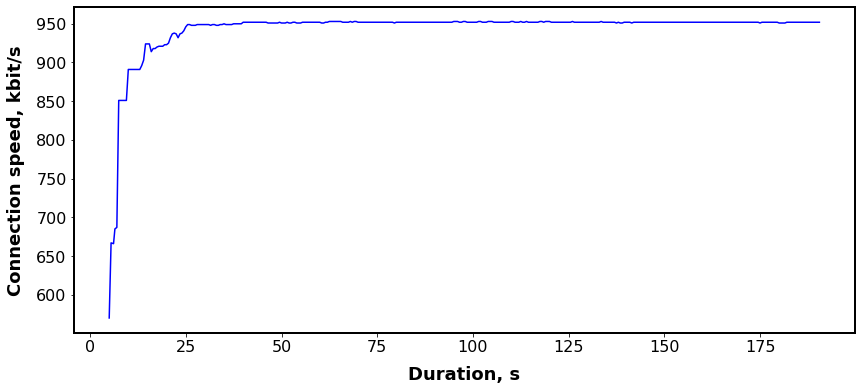

In [20]:
fig, ax1 = plt.subplots()
fig.set_size_inches((14,6))
ax1.set_ylabel('Connection speed, kbit/s', color='black', fontsize=18, fontweight='bold', labelpad=11)
ax1.set_xlabel('Duration, s', color='black', fontsize=18, fontweight='bold', labelpad=11)
#ax1.set_xticks()
ax1.plot(df.timestamp_utc_ms[10:]/1000, df.connection_speed[10:], color='b')

for _k in ['bottom', 'top', 'left', 'right']:
  
  ax1.spines[_k].set_linewidth(2)
  ax1.spines[_k].set_color('k')
  
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
  label.set_fontsize(16)
  
fig.savefig("conn_speed_1500kbit.png", dpi=1100)

In [13]:
df['chunks'] = df.network_activity*8/df.connection_speed